In [159]:
import numpy as np
import argparse
import imutils
import cv2
import os
import matplotlib.pyplot as plt
import doxapy
import sys

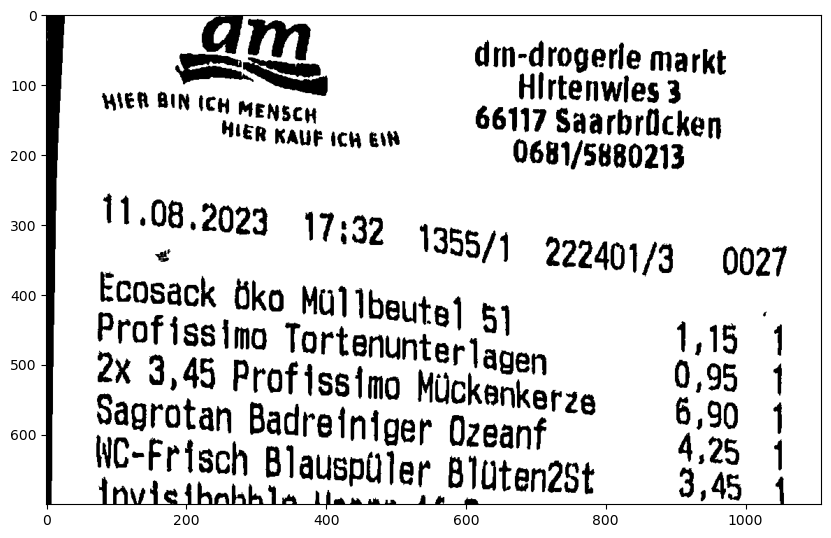

In [172]:
inputfile = '/home/elena/Documents/Projects/kassenzettel-django-react/testings/receipe-upload-_oqp9us3.jpg'
#inputfile = '/home/elena/Documents/Projects/kassenzettel-django-react/testings/testbild.png'
img = cv2.imread(inputfile, cv2.IMREAD_GRAYSCALE)
start = 200
stop = start + 700

img_snippet = img[start:stop,:]
img_copy = cv2.cvtColor(img_snippet,cv2.COLOR_GRAY2RGB)

binary_image = np.empty(img_snippet.shape, img_snippet.dtype)
sauvola = doxapy.Binarization(doxapy.Binarization.Algorithms.ISAUVOLA)
sauvola.initialize(img_snippet)
sauvola.to_binary(binary_image, {"window": 45, "k": 0.009})


#Plot the snippet
plt.figure(figsize=(10,10))
plt.imshow(binary_image, cmap='gray')
plt.show()

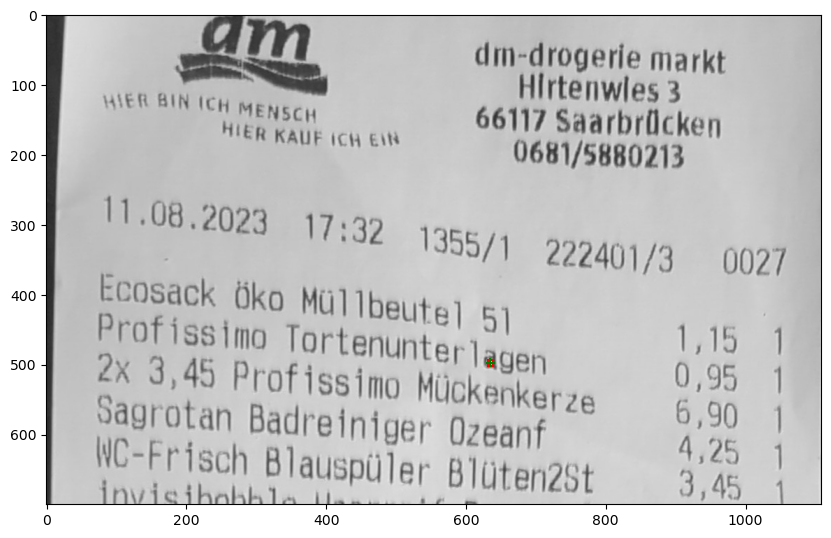

In [176]:
#Invert the binary image
binary_image = cv2.bitwise_not(binary_image)
# Calc connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

# Plot centers and bounding boxes of connected components in the snippet
plt.figure(figsize=(10,10))
plt.imshow(img_copy, cmap='gray')
for i in range(70,71):#range(1,num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    cx = centroids[i,0]
    cy = centroids[i,1]
    # Plot bounding box as rectangle
    plt.plot([x,x+w],[y,y],'r-')
    plt.plot([x,x],[y,y+h],'r-')
    plt.plot([x,x+w],[y+h,y+h],'r-')
    plt.plot([x+w,x+w],[y,y+h],'r-')

    # Plot center as cross
    plt.plot([cx-5,cx+5],[cy,cy],'g-')
    plt.plot([cx,cx],[cy-5,cy+5],'g-')

plt.show()

In [170]:
# Calculate the mean vector and the covariance matrix of the pixels in each connected component
means = np.empty((num_labels,2))
covs = np.empty((num_labels,2,2))
eigenvalues = np.empty((num_labels,2))
eigenvectors = np.empty((num_labels,2,2))

img_copy = cv2.cvtColor(img_snippet,cv2.COLOR_GRAY2RGB)

labelsForDelete = []

for i in range(1,num_labels):
    mask = np.zeros(binary_image.shape, np.uint8)
    mask[labels == i] = 255
    
    xy_coords = np.flip(np.column_stack(np.where(mask == 255)), axis=1)
    #means[i] = np.mean(xy_coords, axis=0)  # Is equal to the centroid
    covs[i] = np.cov(xy_coords, rowvar=False)

    # Calculate the eienvalues and eigenvectors of the covariance matrix
    eigenvalues[i], eigenvectors[i] = np.linalg.eig(covs[i])

    #Sort the eigenvalues and eigenvectors
    idx = eigenvalues[i].argsort()[::-1]
    eigenvalues[i] = eigenvalues[i][idx]
    eigenvectors[i] = eigenvectors[i][:,idx]

    #If eigenvalue1 / eigenvalue2 > 15, remove the corresponding connected component
    if eigenvalues[i,0] / eigenvalues[i,1] > 15**2:
        labelsForDelete.append(i)


#Delete the connected components in list
labels = np.delete(labels, labelsForDelete, axis=0)
num_labels = num_labels - len(labelsForDelete)
stats = np.delete(stats, labelsForDelete, axis=0)
centroids = np.delete(centroids, labelsForDelete, axis=0)
eigenvalues = np.delete(eigenvalues, labelsForDelete, axis=0)
eigenvectors = np.delete(eigenvectors, labelsForDelete, axis=0)

# Plot eigenvectors and eigenvalues as ellipses
plt.figure(figsize=(10,10))
print(num_labels)
for i in range(1,num_labels):
    cx = centroids[i,0]
    cy = centroids[i,1]
    
    # Plot eigenvalues as ellipses
    cv2.ellipse(img_copy,(int(centroids[i,0]),int(centroids[i,1])),(int(np.sqrt(eigenvalues[i,0])),int(np.sqrt(eigenvalues[i,1]))),np.rad2deg(np.arctan2(eigenvectors[i,0,1],eigenvectors[i,0,0])),0,360,(0,255,0),2)
plt.imshow(img_copy, cmap='gray')
plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 700 but corresponding boolean dimension is 699

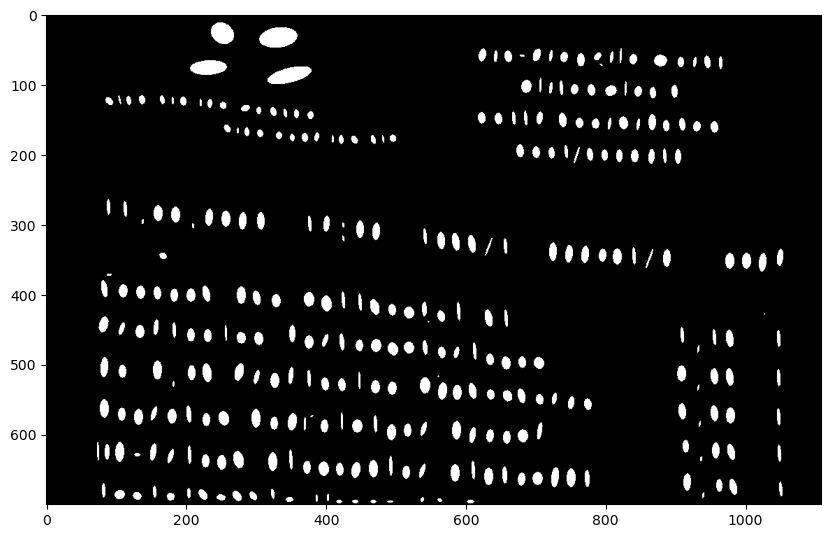

In [143]:
# Create a new image with only the ellipses
ellipseMask = np.zeros(binary_image.shape, np.uint8)
for i in range(1,num_labels):
    # Plot eigenvalues as ellipses in black and white image
    cv2.ellipse(ellipseMask,(int(centroids[i,0]),int(centroids[i,1])),(int(np.sqrt(eigenvalues[i,0])),int(np.sqrt(eigenvalues[i,1]))),np.rad2deg(np.arctan2(eigenvectors[i,0,1],eigenvectors[i,0,0])),0,360,(255,255,255),-1)

plt.figure(figsize=(10,10))
plt.imshow(ellipseMask, cmap='gray')
plt.show()

[661.46630728  60.69811321]
(700, 256)


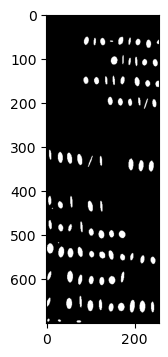

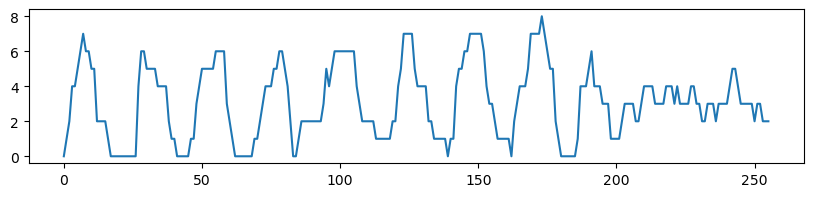

In [153]:
# Project the ellipses to the x-axis
#for n in range(0,ellipseMask.shape[0]):
#    s = ellipseMask[n,:].tostring()
#    print(s)
from itertools import groupby 

#Itertools solution
def changes_in(sequence):
    return len(list(groupby(sequence))) - 1

#Bitwise solution: Ruffly 2 times faster than itertools solution
#https://stackoverflow.com/questions/70300297/is-there-a-built-in-python-function-to-count-bit-flip-in-a-binary-string#:~:text=There%20is%20a%20very%20fast%20way%20to%20do,string%20to%20count%20the%20number%20of%20bit%20flips.
def changes_in_bitoperation(sequence):
    # Convert the sequence to an integer: [0,1,1,0,1] -> 0b01101
    s = np.array2string(sequence, separator='',max_line_width=1000000)
    n = int(s[1:-1], 2)

    # Build a binary mask to skip the most significant bit of n: 0b01101 -> 0b01111
    mask = (1 << (len(s)-1)) - 1

    # Check if the ith bit of n is different from the (i+1)th bit of n using a bit-wise XOR:
    # 0b01101 & 0b01111 -> 0b1101  (discard the first bit)
    # 0b01101 >> 1      -> 0b0110
    # 0b1101 ^ 0b0110   -> 0b1011
    bitFlips = (n & mask) ^ (n >> 1)

    # Convert the integer back to a string and count the bit flips: 0b1011 -> "0b1011" -> 3
    flipCount = bin(bitFlips).count('1')
    return flipCount

Np = 256

xprojection = np.zeros(Np)

centroidNum = 7
print(centroids[centroidNum,:])

paddedMask = np.zeros((ellipseMask.shape[0],Np), np.uint8)

if centroids[centroidNum,0]-Np/2 < 0 and centroids[centroidNum,0]+Np/2 < ellipseMask.shape[1]:
    #Pad at the beginning
    paddedMask = np.pad(ellipseMask, ((0,0),(int(Np/2 - centroids[centroidNum,0]),0)), 'reflect')[:,0:Np]
    print(paddedMask.shape)

elif centroids[centroidNum,0]-Np/2 > 0 and centroids[centroidNum,0]+Np/2 > ellipseMask.shape[1]:
    #Pad at the end
    paddedMask = np.pad(ellipseMask, ((0,0),(0,int(Np/2 - (ellipseMask.shape[1] - centroids[centroidNum,0])))), 'reflect')[:,0:Np]
elif centroids[centroidNum,0]-Np/2 < 0 and centroids[centroidNum,0]+Np/2 > ellipseMask.shape[1]:
    #Pad at the beginning and at the end
    paddedMask = np.pad(ellipseMask, ((0,0),(int(Np/2 - centroids[centroidNum,0]),int(Np/2 - (ellipseMask.shape[1] - centroids[centroidNum,0])))), 'reflect')[:,0:Np]
else:
    #No padding
    paddedMask = ellipseMask[:,int(centroids[centroidNum,0]-Np/2):int(centroids[centroidNum,0]+Np/2)]
    print(paddedMask.shape)

#plot paddedMask
plt.figure(figsize=(4,4))
plt.imshow(paddedMask, cmap='gray')
plt.show()


for rowNumber in range(0,paddedMask.shape[1]):
    row = (paddedMask[:,rowNumber]/255).astype(np.uint8)
    flipps = changes_in_bitoperation(row)
    if row[0] > 0 and row[-1] == 0:
        flipps += 1
    elif row[-1] > 0 and row[0] == 0:
        flipps += 1
    elif row[0] > 0 and row[-1] > 0:
        flipps += 2

    xprojection[rowNumber] = flipps/2

#Plot the xprojection as line chart
plt.figure(figsize=(10,2))
plt.plot(xprojection)
plt.show()




In [152]:
epsilon = 0.01
kp = 5

Vp = 0
#Check if xprojection is smaler or equal than 3 for all values
if np.all(xprojection <= 3):
    Vp = epsilon
else:
    # Calculate the rfft of the xprojection
    dft = np.fft.rfft(xprojection)
    #print(dft)

    #Check if dft[kp] is local maximum
    if kp > 0 and kp < len(dft)-1:
        if np.abs(dft[kp]) > np.abs(dft[kp-1]) and np.abs(dft[kp]) > np.abs(dft[kp+1]):
            Vp = -np.log(np.abs(dft[kp])**2/np.abs(dft[0])**2)
        else:
            Vp = epsilon
            print("kp is not local maximum")

print(Vp)

kp is not local maximum
0.01
